In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Import libararies
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import DenseNet121, MobileNetV2, ResNet50
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.layers import Dropout

In [5]:
data_dir = '/content/drive/MyDrive/PROJEKT KONCOWY /data'
train = pd.read_csv(os.path.join(data_dir, 'train', '_classes.csv'))
val = pd.read_csv(os.path.join(data_dir, 'valid', '_classes.csv'))
test = pd.read_csv(os.path.join(data_dir, 'test', '_classes.csv'))

In [6]:
#ImagedataGenerator
datagen = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.5, 1.5]
)


#train
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=os.path.join(data_dir, 'train'),
    x_col='filename',
    y_col=train.columns[1:],
    target_size=(128, 128),
    batch_size=32,
    class_mode='raw'
)

# val
val_generator = datagen.flow_from_dataframe(
    dataframe=val,
    directory=os.path.join(data_dir, 'valid'),
    x_col='filename',
    y_col=train.columns[1:],
    target_size=(128, 128),
    batch_size=32,
    class_mode='raw'
)

#test
test_generator = datagen.flow_from_dataframe(
    dataframe=test,
    directory=os.path.join(data_dir, 'test'),
    x_col='filename',
    y_col=test.columns[1:],
    target_size=(128, 128),
    batch_size=32,
    class_mode='raw'
)


Found 1716 validated image filenames.
Found 254 validated image filenames.
Found 203 validated image filenames.


In [7]:
def plot_history(history):
    plt.figure(figsize=[8,6])

    plt.plot(history.history['loss'],'r',linewidth=3.0)
    plt.plot(history.history['val_loss'],'b',linewidth=3.0)

    plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Loss Curves',fontsize=16)
    plt.show()

    plt.figure(figsize=[8,6])

    plt.plot(history.history['accuracy'], 'r', linewidth=3.0)
    plt.plot(history.history['val_accuracy'], 'b',linewidth=3.0)

    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)

In [8]:
def plot_random_predictions(model, data_generator, data_dir, num_images=3):
    for _ in range(num_images):
        random_index = np.random.randint(0, len(data_generator.filenames))
        random_image_path = os.path.join(data_dir, data_generator.directory,
                                         data_generator.filenames[random_index])

        img = image.load_img(random_image_path, target_size=(128, 128))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0

        prediction = model.predict(img_array)

        predicted_class = np.argmax(prediction)
        class_labels = train.columns[1:]
        predicted_label = class_labels[predicted_class]

        plt.figure()
        plt.imshow(img)
        plt.title(f'Predicted Class: {predicted_label}')
        plt.axis('off')

In [9]:
#Parameters
input_shape = (128, 128, 3)
num_classes = 24
epochs = 100

#Model

model1 = models.Sequential()

model1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.01)))
model1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.01)))
model1.add(layers.BatchNormalization())
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(Dropout(0.5))

model1.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model1.add(layers.BatchNormalization())
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(Dropout(0.5))

model1.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model1.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model1.add(layers.BatchNormalization())
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(Dropout(0.5))

model1.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model1.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model1.add(layers.BatchNormalization())
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(Dropout(0.5))

model1.add(layers.Flatten())
model1.add(layers.Dense(128, activation='relu'))
model1.add(layers.Dense(num_classes, activation='softmax'))

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True)

model1.compile(optimizer=Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history1 = model1.fit(train_generator,
                    epochs=epochs,
                    validation_data=val_generator,
                    callbacks=[early_stopping])

model1.save('/content/drive/MyDrive/PROJEKT KONCOWY /own_model.h5')

test_loss_1, test_accuracy_1 = model1.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy_1}')

Epoch 1/100
54/54 [==============================] - 609s 11s/step - loss: 11.4190 - accuracy: 0.1002 - val_loss: 11.0995 - val_accuracy: 0.0630
Epoch 2/100
54/54 [==============================] - 15s 275ms/step - loss: 9.9714 - accuracy: 0.2360 - val_loss: 9.9831 - val_accuracy: 0.1102
Epoch 3/100
54/54 [==============================] - 14s 258ms/step - loss: 8.7569 - accuracy: 0.3351 - val_loss: 9.6936 - val_accuracy: 0.1299
Epoch 4/100
54/54 [==============================] - 16s 292ms/step - loss: 7.6077 - accuracy: 0.4545 - val_loss: 7.9001 - val_accuracy: 0.3583
Epoch 5/100
54/54 [==============================] - 15s 284ms/step - loss: 6.6743 - accuracy: 0.5047 - val_loss: 7.6915 - val_accuracy: 0.3268
Epoch 6/100
54/54 [==============================] - 15s 276ms/step - loss: 5.8318 - accuracy: 0.5559 - val_loss: 6.3480 - val_accuracy: 0.4331
Epoch 7/100
54/54 [==============================] - 15s 284ms/step - loss: 5.0591 - accuracy: 0.6317 - val_loss: 5.5696 - val_accuracy

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 85s 14s/step - loss: 1.6818 - accuracy: 0.8276
Test Accuracy: 0.8275862336158752


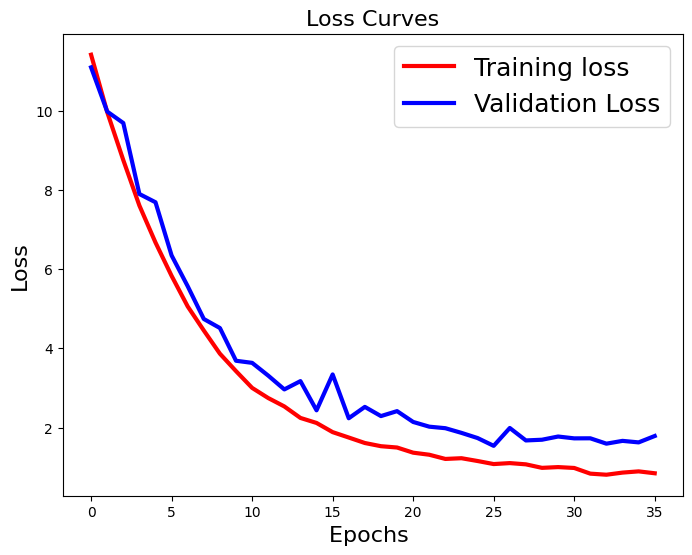

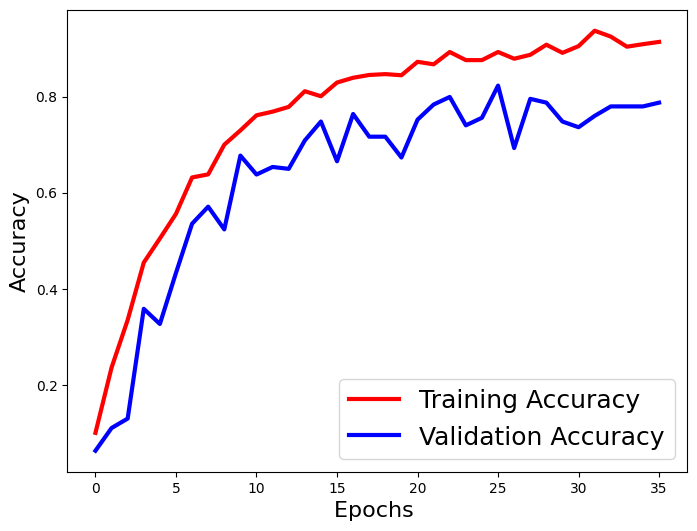

In [10]:
plot_history(history1)

1/1 [==============================] - 0s 20ms/step


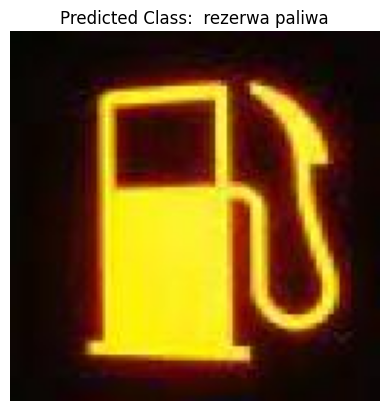

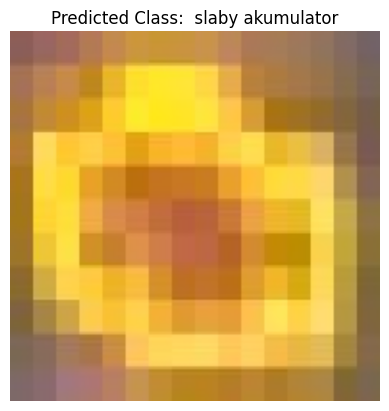

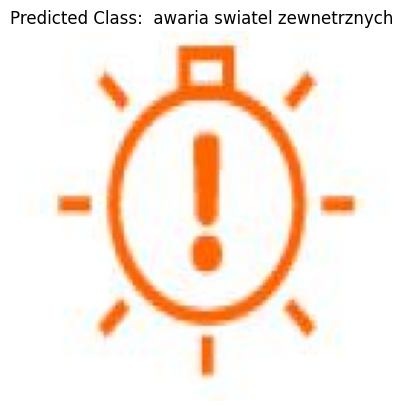

In [11]:
plot_random_predictions(model1, test_generator, data_dir)

In [12]:
#Parameters
input_shape = (128, 128, 3)
num_classes = 24
epochs = 200

#Model

base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
    )

base_model.trainable = True

model2 = models.Sequential()
model2.add(base_model),
model2.add(layers.GlobalAveragePooling2D())
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(num_classes, activation='softmax'))

model2.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=20,
                               restore_best_weights=True)

history2 = model2.fit(
    train_generator,
    epochs=epochs,
    validation_data=(val_generator),
    callbacks=[early_stopping]
)

model2.save("/content/drive/MyDrive/PROJEKT KONCOWY /DenseNet_model.h5")

test_loss_2, test_accuracy_2 = model2.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy_2}')

29084464/29084464 [==============================] - 0s 0us/step
Epoch 1/200
54/54 [==============================] - 88s 428ms/step - loss: 3.8544 - accuracy: 0.0332 - val_loss: 3.2859 - val_accuracy: 0.0354
Epoch 2/200
54/54 [==============================] - 17s 314ms/step - loss: 3.6917 - accuracy: 0.0455 - val_loss: 3.2161 - val_accuracy: 0.0512
Epoch 3/200
54/54 [==============================] - 17s 312ms/step - loss: 3.5466 - accuracy: 0.0466 - val_loss: 3.1761 - val_accuracy: 0.0433
Epoch 4/200
54/54 [==============================] - 17s 308ms/step - loss: 3.4268 - accuracy: 0.0571 - val_loss: 3.1369 - val_accuracy: 0.0709
Epoch 5/200
54/54 [==============================] - 17s 312ms/step - loss: 3.4088 - accuracy: 0.0594 - val_loss: 3.1091 - val_accuracy: 0.1024
Epoch 6/200
54/54 [==============================] - 17s 312ms/step - loss: 3.2968 - accuracy: 0.0618 - val_loss: 3.0921 - val_accuracy: 0.0984
Epoch 7/200
54/54 [==============================] - 17s 314ms/step - l

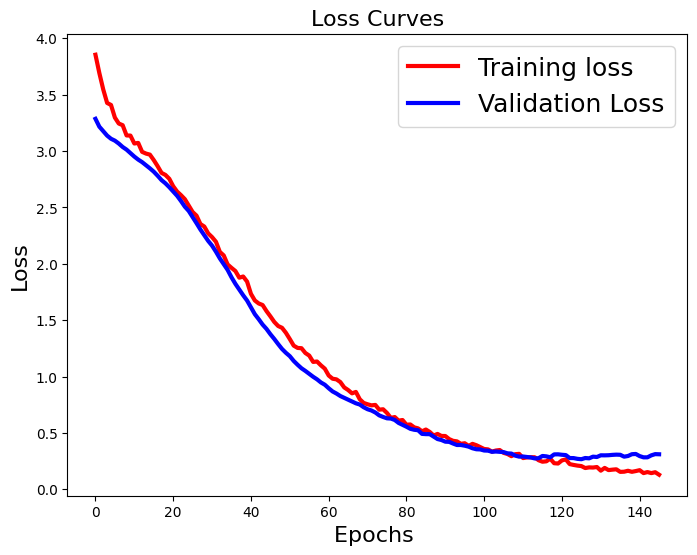

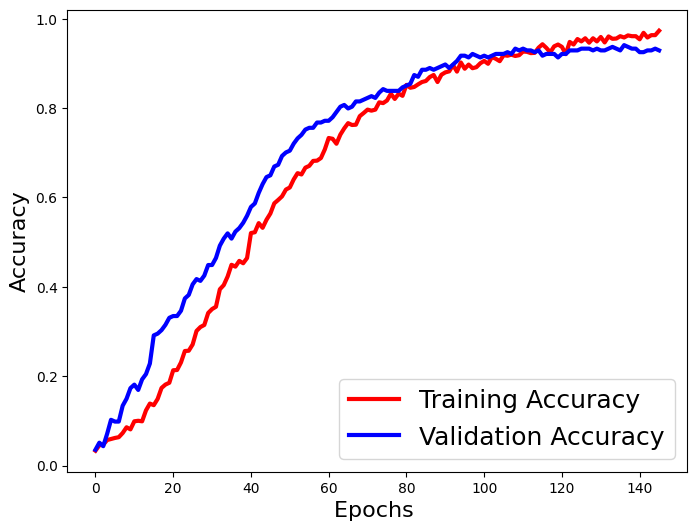

In [13]:
plot_history(history2)

1/1 [==============================] - 0s 28ms/step


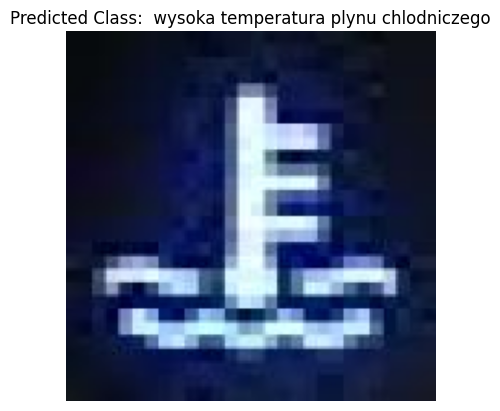

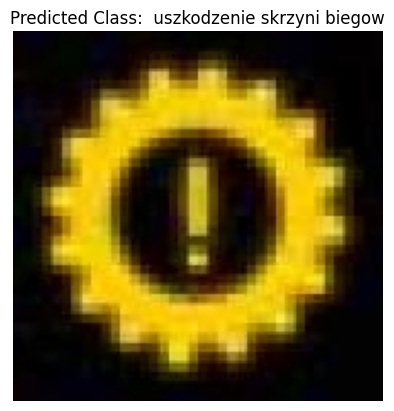

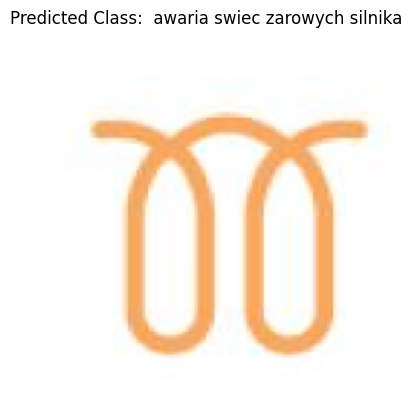

In [14]:
plot_random_predictions(model2, test_generator, data_dir)

In [15]:
#Parameters
input_shape = (128, 128, 3)
num_classes = 24
epochs = 150

#Model
base_model = MobileNetV2(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet')

base_model.trainable = True

model3 = models.Sequential()
model3.add(base_model)
model3.add(layers.GlobalAveragePooling2D())
model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(24, activation='softmax'))

early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=10,
                               restore_best_weights=True)

model3.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history3 = model3.fit(train_generator,
                    epochs=epochs,
                    validation_data=val_generator,
                    callbacks=[early_stopping])

model3.save("/content/drive/MyDrive/PROJEKT KONCOWY /MobileNetV2_model.h5")

test_loss_3, test_accuracy_3 = model3.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy_3}')

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/150
54/54 [==============================] - 41s 288ms/step - loss: 4.1545 - accuracy: 0.0408 - val_loss: 3.4647 - val_accuracy: 0.0315
Epoch 2/150
54/54 [==============================] - 15s 267ms/step - loss: 3.9589 - accuracy: 0.0402 - val_loss: 3.3868 - val_accuracy: 0.0197
Epoch 3/150
54/54 [==============================] - 15s 276ms/step - loss: 3.7669 - accuracy: 0.0559 - val_loss: 3.3177 - val_accuracy: 0.0118
Epoch 4/150
54/54 [==============================] - 15s 273ms/step - loss: 3.6013 - accuracy: 0.0670 - val_loss: 3.2579 - val_accuracy: 0.0354
Epoch 5/150
54/54 [==============================] - 14s 258ms/step - loss: 3.5639 - accuracy: 0.0676 - val_loss: 3.2076 - val_accuracy: 0.0315
Epoch 6/150
54/54 [==============================] - 15s 274ms/step - loss: 3.4351 - accuracy: 0.0688 - val_loss: 3.1683 - val_accuracy: 0.0433
Epoch 7/150
54/54 [==============================] - 15s 274ms/step - los

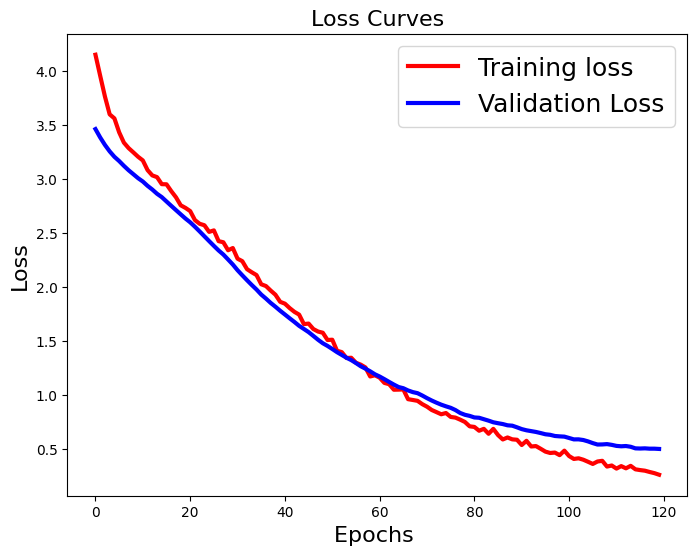

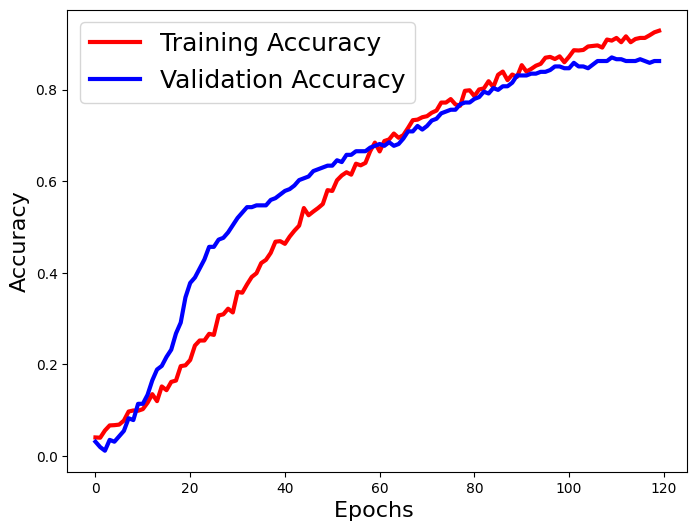

In [16]:
plot_history(history3)

1/1 [==============================] - 0s 37ms/step


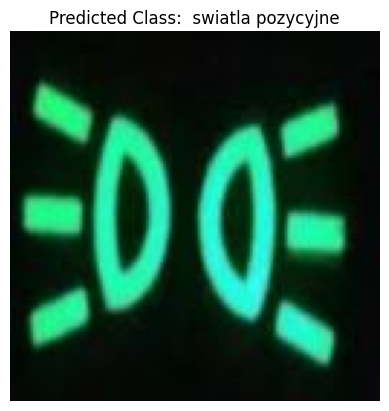

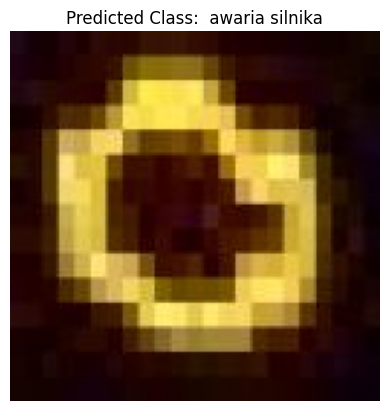

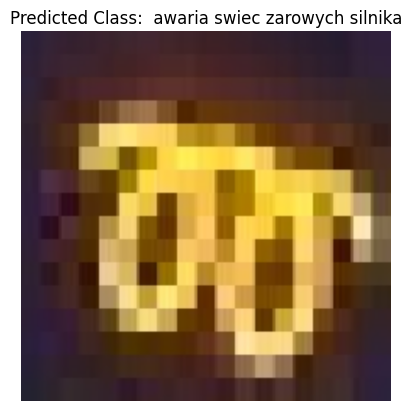

In [17]:
plot_random_predictions(model3, test_generator, data_dir)

In [20]:
#Parameters
input_shape = (128, 128, 3)
num_classes = 24
epochs = 150

#Model
base_model = ResNet50(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet')

base_model.trainable = False

model4 = models.Sequential()
model4.add(base_model)
model4.add(layers.GlobalAveragePooling2D())
model4.add(layers.Dense(256, activation='relu'))
model4.add(layers.Dense(24, activation='softmax'))

early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=10,
                               restore_best_weights=True)

model4.compile(optimizer=Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history4 = model4.fit(train_generator,
                    epochs=epochs,
                    validation_data=val_generator,
                    callbacks=[early_stopping])

model4.save("/content/drive/MyDrive/PROJEKT KONCOWY /ResNet50_model.h5")

test_loss_4, test_accuracy_4 = model4.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy_4}')

Epoch 1/150
54/54 [==============================] - 45s 785ms/step - loss: 3.1067 - accuracy: 0.0682 - val_loss: 3.1275 - val_accuracy: 0.0984
Epoch 2/150
54/54 [==============================] - 14s 262ms/step - loss: 3.0242 - accuracy: 0.0985 - val_loss: 3.0818 - val_accuracy: 0.1063
Epoch 3/150
54/54 [==============================] - 16s 297ms/step - loss: 2.9697 - accuracy: 0.1230 - val_loss: 3.0474 - val_accuracy: 0.0787
Epoch 4/150
54/54 [==============================] - 15s 273ms/step - loss: 2.9297 - accuracy: 0.1340 - val_loss: 2.9606 - val_accuracy: 0.1732
Epoch 5/150
54/54 [==============================] - 14s 260ms/step - loss: 2.9009 - accuracy: 0.1568 - val_loss: 2.9493 - val_accuracy: 0.1732
Epoch 6/150
54/54 [==============================] - 14s 264ms/step - loss: 2.8722 - accuracy: 0.1562 - val_loss: 2.9087 - val_accuracy: 0.1811
Epoch 7/150
54/54 [==============================] - 14s 264ms/step - loss: 2.8364 - accuracy: 0.1503 - val_loss: 2.9095 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 1s 123ms/step - loss: 1.4715 - accuracy: 0.6158
Test Accuracy: 0.6157635450363159


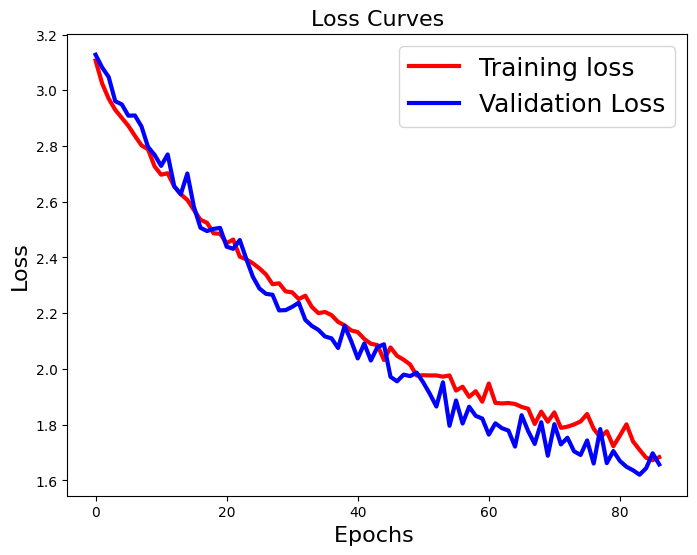

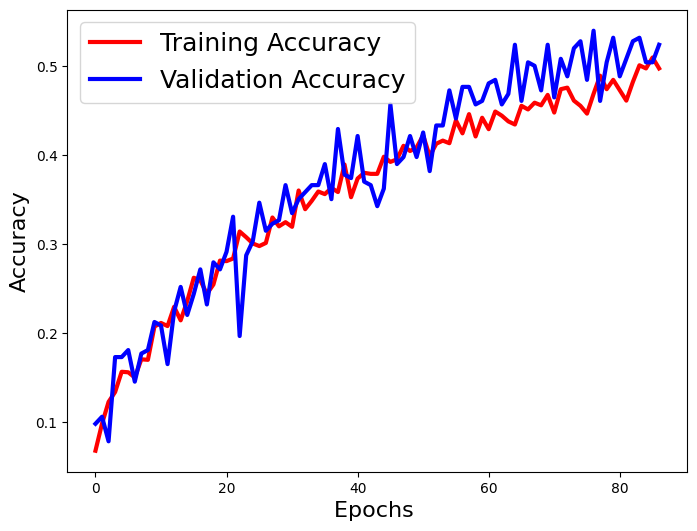

In [21]:
plot_history(history4)

1/1 [==============================] - 0s 36ms/step


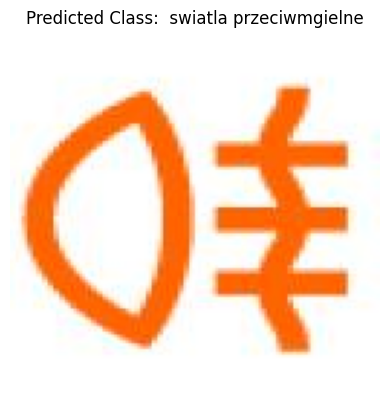

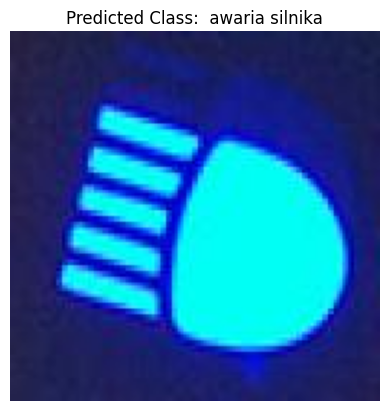

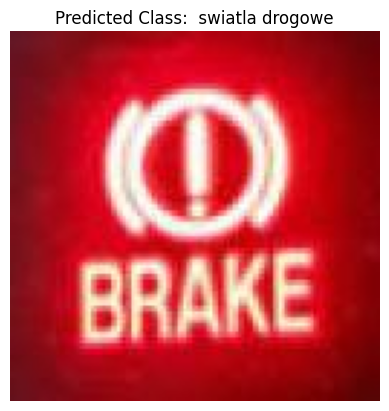

In [22]:
plot_random_predictions(model4, test_generator, data_dir)

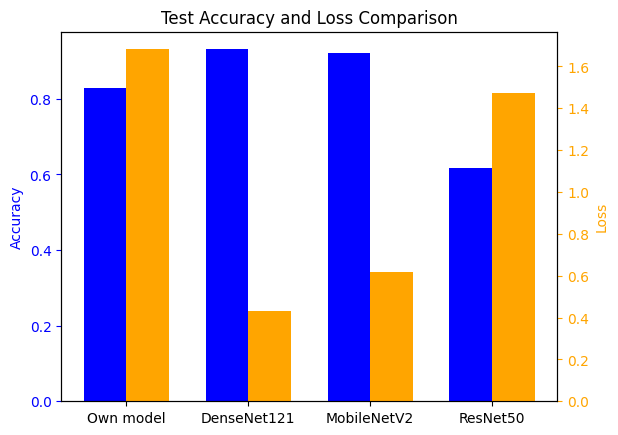

In [23]:
models = ['Own model', 'DenseNet121', 'MobileNetV2', 'ResNet50']

test_accuracies = [test_accuracy_1, test_accuracy_2,
                   test_accuracy_3,test_accuracy_4]

test_losses = [test_loss_1, test_loss_2,
               test_loss_3, test_loss_4]

bar_width = 0.35
index = np.arange(len(models))

fig, ax1 = plt.subplots()

ax1.bar(index, test_accuracies, bar_width, label='Accuracy', color='blue')
ax1.set_ylabel('Accuracy', color='blue')
ax1.tick_params('y', colors='blue')

ax2 = ax1.twinx()
ax2.bar(index + bar_width, test_losses, bar_width, label='Loss', color='orange')
ax2.set_ylabel('Loss', color='orange')
ax2.tick_params('y', colors='orange')

plt.title('Test Accuracy and Loss Comparison')
plt.xticks(index + bar_width / 2, models)
plt.show()
